# Прогнозирование оттока клиентов в телеком компании

Необходимо подготовить модель для прогнозирования оттока клиентов, с целью определения и удержания таких клиентов за счет специальных предложений.

### Содержание:

#### 1) <a href='#EDA'> Исследовательский анализ данных / предобработка</a>
- <a href='#First look'> Изучение данных</a>
- <a href='#Preprocessing'> Предобработка</a>
- <a href='#New features'> Создание новых признаков</a>
- <a href='#Vizualization'> Исследовательский анализ данных / визуализация</a>
- <a href='#EDA conclusion'> Вывод по EDA</a>

#### 2) <a href='#Model training'> Обучение модели</a>
- <a href='#Ordinal Encoding'> Кодирование категориальных признаков</a>
- <a href='#Traintestsplit'> Подготовка обучающей и тестовой выборок</a>
- <a href='#Scaling'> Масштабирование</a>
- <a href='#Results table'> Подготовка таблицы с результатами</a>
- <a href='#Logistic Regression'> Logistic Regression</a>
- <a href='#LGB'> LightGBM</a>
- <a href='#XGBoost'> XGBoost</a>
- <a href='#Logistic Regression + LightGBM'> Logistic Regression + LightGBM</a>

#### 3) <a href='#Conclusion'> Вывод</a>

<a id='EDA'></a>
## Исследовательский анализ данных / предобработка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, plot_confusion_matrix, roc_curve, classification_report
from sklearn.utils import shuffle

import lightgbm
import xgboost

from hyperopt import fmin, tpe, hp, space_eval

In [2]:
contract = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP15\\contract.csv', index_col='customerID')
internet = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP15\\internet.csv', index_col='customerID')
personal = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP15\\personal.csv', index_col='customerID')
phone = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP15\\phone.csv', index_col='customerID')

<a id='First look'></a>
### Изучение данных

In [3]:
print('Contract dataframe')
display(contract.head())
print('Internet dataframe')
display(internet.head())
print('Personal dataframe')
display(personal.head())
print('Phone dataframe')
display(phone.head())

Contract dataframe


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Internet dataframe


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


Personal dataframe


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


Phone dataframe


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [4]:
contract.shape, internet.shape, personal.shape, phone.shape

((7043, 7), (5517, 7), (7043, 4), (6361, 1))

In [5]:
print('Кол-во уникальных пользователей:', pd.concat([contract, internet, personal, phone]).index.nunique())

Кол-во уникальных пользователей: 7043


Объединяю все в один датафрейм для удобства работы:

In [6]:
telecom = contract.join([internet, personal, phone])

In [7]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   int64  
 16  Partner           7043 non-null 

<a id='Preprocessing'></a>
### Предобработка

BeginDate необходимо перевести в формат datetime, TotalCharges во float:

In [8]:
telecom['BeginDate'] = pd.to_datetime(telecom['BeginDate'])
# Пустые значения отмечаю нулями (все такие клиенты заключили контракт в феврале 2020, и видимо еще не оплачивали счета)
telecom.loc[telecom['TotalCharges'] == ' ', 'TotalCharges'] = 0
telecom['TotalCharges'] = telecom['TotalCharges'].astype('float64')

In [9]:
telecom['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Было уточнено, что если данные по использованию интернет услуг и телефонии отсутствуют, значит клиент не использует эти услуги.

In [10]:
telecom['PhoneLines'] = telecom['MultipleLines'].apply(lambda x: 'One' if x=='No' else ('Multiple' if x=='Yes' else 'None'))
telecom = telecom.drop('MultipleLines', axis=1)

In [11]:
columns_with_missing_values = []
for i in telecom.columns:
    if telecom[i].isna().sum() > 0:
        columns_with_missing_values.append(i)

In [12]:
for i in columns_with_missing_values:
    print(i, telecom[i].unique(), telecom[i].isna().sum())

InternetService ['DSL' 'Fiber optic' nan] 1526
OnlineSecurity ['No' 'Yes' nan] 1526
OnlineBackup ['Yes' 'No' nan] 1526
DeviceProtection ['No' 'Yes' nan] 1526
TechSupport ['No' 'Yes' nan] 1526
StreamingTV ['No' 'Yes' nan] 1526
StreamingMovies ['No' 'Yes' nan] 1526


In [13]:
for i in columns_with_missing_values:
    telecom[i] = telecom[i].fillna('No')

Смотрю какие значения принимают остальные категориальные признаки:

In [14]:
for i in list(set(telecom.columns).difference(set(columns_with_missing_values))):
    if telecom[i].dtype == 'O':
        print(i, telecom[i].unique())

gender ['Female' 'Male']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
EndDate ['No' '2019-12-01 00:00:00' '2019-11-01 00:00:00' '2019-10-01 00:00:00'
 '2020-01-01 00:00:00']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PaperlessBilling ['Yes' 'No']
Type ['Month-to-month' 'One year' 'Two year']
PhoneLines ['None' 'One' 'Multiple']


In [15]:
telecom.isna().sum().sum()

0

<a id='New features'></a>
### Создание признаков

Так как услуг много, попробую создать более емкую группировку: пользуется интернетом, телефоном или обеими группами услуг:

In [16]:
def user_type (row):
    internet_user = row['InternetService']
    phone_user = row['PhoneLines']
    if (internet_user == 'Fiber optic' or internet_user == 'DSL') and (phone_user=='One' or phone_user=='Multiple'):
        return 'Internet and phone user'
    elif (internet_user == 'Fiber optic' or internet_user == 'DSL'):
        return 'Internet only user'
    elif phone_user=='One' or phone_user=='Multiple':
        return 'Phone only user'
    else:
        return 'Unknown type of user'

In [17]:
telecom['UserType'] = telecom.apply(user_type, axis=1)

Рассчитываю кол-во месяцев, в течении которого клиент пользовался / продолжает пользоваться нашими услугами:

In [18]:
telecom['EndDate2'] = telecom['EndDate'].apply(lambda x: '2020-02-01' if x=='No' else x)
telecom['EndDate2'] = pd.to_datetime(telecom['EndDate2'])
telecom['MonthsWithUs'] = round((telecom['EndDate2'] - telecom['BeginDate'])/np.timedelta64(1, 'M'), 0)

Считаю кол-во используемых услуг:

In [19]:
def services_count (row):
    count = 0
    if row['InternetService'] != 'No':
        count += 1
    if row['OnlineSecurity'] == 'Yes':
        count += 1
    if row['OnlineBackup'] == 'Yes':
        count += 1
    if row['DeviceProtection'] == 'Yes':
        count += 1
    if row['TechSupport'] == 'Yes':
        count += 1
    if row['StreamingTV'] == 'Yes':
        count += 1
    if row['StreamingMovies'] == 'Yes':
        count += 1
    if row['PhoneLines'] == 'One':
        count += 1
    if row['PhoneLines'] == 'Multiple':
        count += 2
    return count

In [20]:
telecom['ServicesCount'] = telecom.apply(services_count, axis=1).astype('float64')

Группирую пользователей по ежемесячным затратам на услуги:

In [21]:
def group_by_charges (x):
    if x <= 20:
        return 1
    elif x <= 40:
        return 2
    elif x <= 60:
        return 3
    elif x <= 80:
        return 4
    elif x <= 100:
        return 5
    else:
        return 6

In [22]:
telecom['ChargesGroup'] = telecom['MonthlyCharges'].apply(group_by_charges)

Группирую пользователей по кол-ву месяцев, в течении которых они пользовались / продолжают пользоваться нашими услугами:

In [23]:
def group_by_months (x):
    if x <= 1:
        return 1
    elif x <= 10:
        return 2
    elif x <= 20:
        return 3
    elif x <= 30:
        return 4
    elif x <= 40:
        return 5
    elif x <= 60:
        return 6    
    else:
        return 7

In [24]:
telecom['MonthsGroup'] = telecom['MonthsWithUs'].apply(group_by_months)

Добавляю бинарные признаки, связанные с кол-вом месяцев использования услуг и ежемесячным платежом (границы взяты из EDA, который идет следующим шагом):

In [25]:
telecom['Below20Months'] = telecom['MonthsWithUs'].apply(lambda x: 1 if x<20 else 0)
telecom['Below65MonthPayment'] = telecom['MonthlyCharges'].apply(lambda x: 1 if x<65 else 0)

In [26]:
telecom['Churn'] = telecom['EndDate'].apply(lambda x: 0 if x=='No' else 1)

In [27]:
telecom = telecom.drop(['BeginDate', 'EndDate', 'EndDate2'], axis=1)

In [28]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 7043 non-null   object 
 1   PaperlessBilling     7043 non-null   object 
 2   PaymentMethod        7043 non-null   object 
 3   MonthlyCharges       7043 non-null   float64
 4   TotalCharges         7043 non-null   float64
 5   InternetService      7043 non-null   object 
 6   OnlineSecurity       7043 non-null   object 
 7   OnlineBackup         7043 non-null   object 
 8   DeviceProtection     7043 non-null   object 
 9   TechSupport          7043 non-null   object 
 10  StreamingTV          7043 non-null   object 
 11  StreamingMovies      7043 non-null   object 
 12  gender               7043 non-null   object 
 13  SeniorCitizen        7043 non-null   int64  
 14  Partner              7043 non-null   object 
 15  Dependents           7043 no

Сохраняю типы данных для дальнейшей работы:

In [29]:
categorical_columns, quantitive_columns = [], []

for i in telecom.columns:
    if telecom[i].dtype == 'float64':
        quantitive_columns.append(i)
    else:
        categorical_columns.append(i)

categorical_columns.remove('Churn')
print('Колонки с категориальными признаками:')
print(categorical_columns)
print()
print('Колонки с количественными признаками:')
print(quantitive_columns)

Колонки с категориальными признаками:
['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneLines', 'UserType', 'ChargesGroup', 'MonthsGroup', 'Below20Months', 'Below65MonthPayment']

Колонки с количественными признаками:
['MonthlyCharges', 'TotalCharges', 'MonthsWithUs', 'ServicesCount']


<a id='Vizualization'></a>
### Исследовательский анализ данных / визуализация

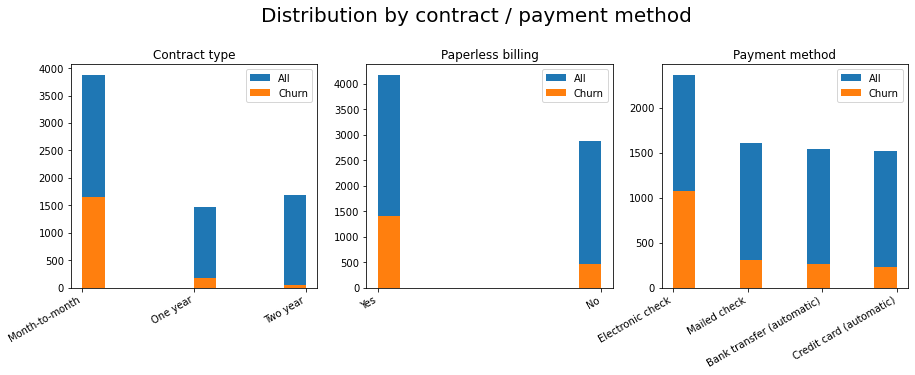

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(telecom['Type'])
ax[0].hist(telecom[telecom['Churn'] == 1]['Type'])
ax[0].set_title('Contract type')
ax[1].hist(telecom['PaperlessBilling'])
ax[1].hist(telecom[telecom['Churn'] == 1]['PaperlessBilling'])
ax[1].set_title('Paperless billing')
ax[2].hist(telecom['PaymentMethod'])
ax[2].hist(telecom[telecom['Churn'] == 1]['PaymentMethod'])
ax[2].set_title('Payment method')

fig.autofmt_xdate()
fig.suptitle('Distribution by contract / payment method', fontsize=20)
fig.subplots_adjust(top=0.82)

for i in range(3):
    ax[i].legend(['All', 'Churn'])

Около половины пользователей предпочитает долгосрочный контракт (1-2 года), 60% пользователей выбирают электронные чеки вместо бумажных. 88% ушедших пользователей пользовались 'Month-to-month' контактом. Можно сделать промежутный вывод, что у тех пользоателей, которые заключают долгосрочный контракт вероятность ухода меньше.

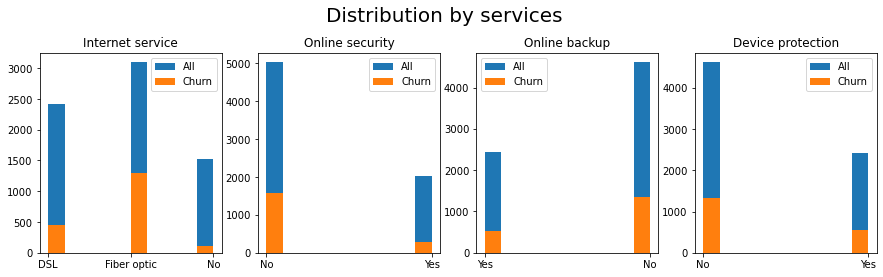

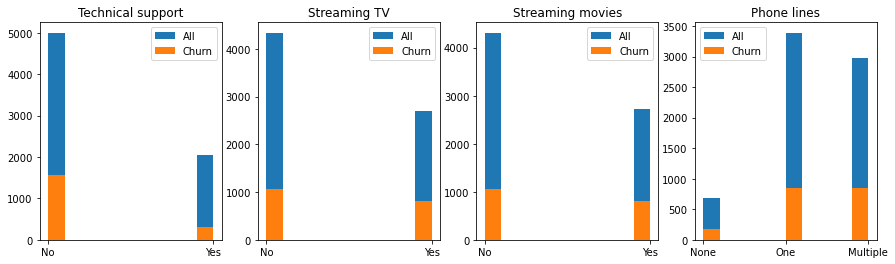

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

ax[0].hist(telecom['InternetService'])
ax[0].hist(telecom[telecom['Churn'] == 1]['InternetService'])
ax[0].set_title('Internet service')
ax[1].hist(telecom['OnlineSecurity'])
ax[1].hist(telecom[telecom['Churn'] == 1]['OnlineSecurity'])
ax[1].set_title('Online security')
ax[2].hist(telecom['OnlineBackup'])
ax[2].hist(telecom[telecom['Churn'] == 1]['OnlineBackup'])
ax[2].set_title('Online backup')
ax[3].hist(telecom['DeviceProtection'])
ax[3].hist(telecom[telecom['Churn'] == 1]['DeviceProtection'])
ax[3].set_title('Device protection')

for i in range(4):
    ax[i].legend(['All', 'Churn'])

fig.suptitle('Distribution by services', fontsize=20)
fig.subplots_adjust(top=0.82)
    
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

ax[0].hist(telecom['TechSupport'])
ax[0].hist(telecom[telecom['Churn'] == 1]['TechSupport'])
ax[0].set_title('Technical support')
ax[1].hist(telecom['StreamingTV'])
ax[1].hist(telecom[telecom['Churn'] == 1]['StreamingTV'])
ax[1].set_title('Streaming TV')
ax[2].hist(telecom['StreamingMovies'])
ax[2].hist(telecom[telecom['Churn'] == 1]['StreamingMovies'])
ax[2].set_title('Streaming movies')
ax[3].hist(telecom['PhoneLines'])
ax[3].hist(telecom[telecom['Churn'] == 1]['PhoneLines'])
ax[3].set_title('Phone lines')

for i in range(4):
    ax[i].legend(['All', 'Churn'])

Наиболее востребованные услуги: Streaming TV/Movies; Наименее востребованные услуги: TechSupport и Online security. Сильных различий по услугам между всеми и ушедшеми пользователями не обнаружено.

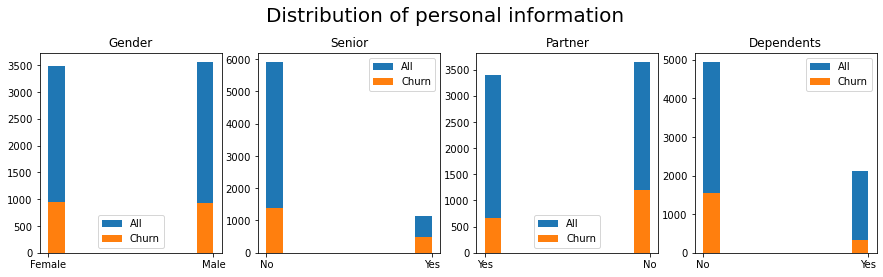

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

ax[0].hist(telecom['gender'])
ax[0].hist(telecom[telecom['Churn'] == 1]['gender'])
ax[0].set_title('Gender')
ax[1].hist(telecom['SeniorCitizen'].apply(lambda x: 'No' if x==0 else 'Yes'))
ax[1].hist(telecom[telecom['Churn'] == 1]['SeniorCitizen'].apply(lambda x: 'No' if x==0 else 'Yes'))
ax[1].set_title('Senior')
ax[2].hist(telecom['Partner'])
ax[2].hist(telecom[telecom['Churn'] == 1]['Partner'])
ax[2].set_title('Partner')
ax[3].hist(telecom['Dependents'])
ax[3].hist(telecom[telecom['Churn'] == 1]['Dependents'])
ax[3].set_title('Dependents')

fig.suptitle('Distribution of personal information', fontsize=20)
fig.subplots_adjust(top=0.82)

for i in range(4):
    ax[i].legend(['All', 'Churn'])

Услугами одинаково часто пользуются как мужчины так и женщины; 16% пользователей - пожилые люди; у 30% пользователей есть дети.
Неженатые/незамужние занимают долю 64% в ушедших пользователях, при том что в общем количестве они занимают 52%.

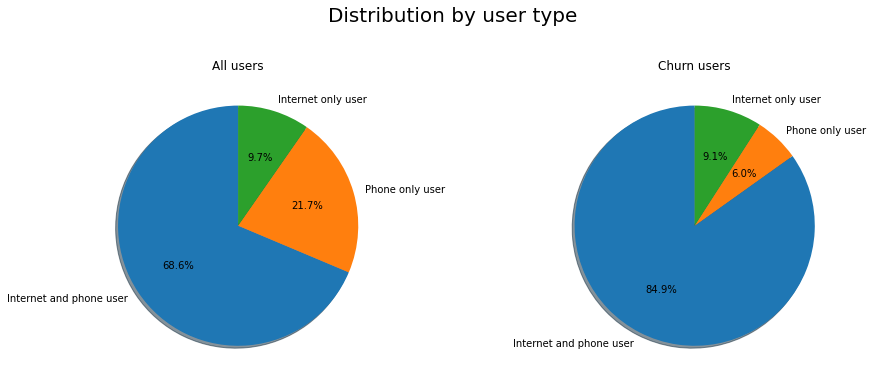

In [33]:
pie_user_type = pd.DataFrame(telecom['UserType'].value_counts(normalize=True)*100)
pie_user_type.columns = ['All users']
pie_user_type['Churn users'] = telecom[telecom['Churn'] == 1]['UserType'].value_counts(normalize=True)*100

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].pie(pie_user_type['All users'], labels=pie_user_type.index, autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].set_title('All users')
ax[1].pie(pie_user_type['Churn users'], labels=pie_user_type.index, autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].set_title('Churn users')

fig.suptitle('Distribution by user type', fontsize=20)
fig.subplots_adjust(top=0.82)

Общая доля пользователей, которая использует и интернет и телефон составляет 69%, при этом в ушедших клиентах эта доля составляет 85%. Доля ушедших, которые пользуются телефоном составляет 6%, в общем распределении эта доля гораздо выше и составляет 22%.

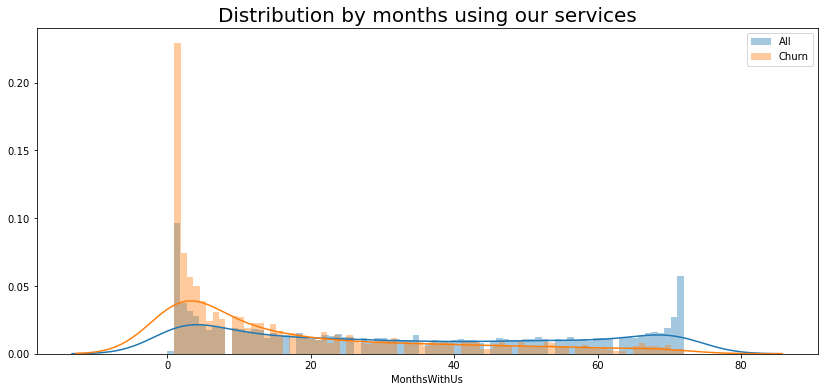

In [34]:
plt.figure(figsize = (14, 6))
sns.distplot(telecom['MonthsWithUs'], label='All', bins=80)
sns.distplot(telecom[telecom['Churn'] == 1]['MonthsWithUs'], label='Churn', bins=80)
plt.title('Distribution by months using our services', fontsize=20)
plt.legend();

Чем дольше клиент пользуется нашими услугами, тем меньше вероятность его ухода. Основная масса уходящих, уходят в течении 20 месяцев (66%). 20% от ушедших пользовались услугами лишь один месяц.

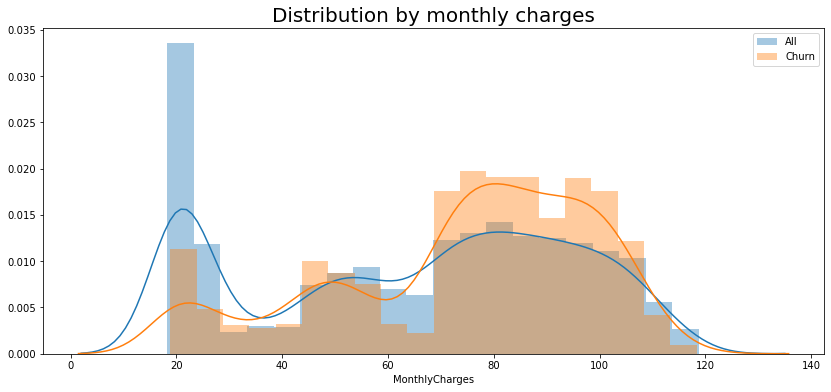

In [35]:
plt.figure(figsize = (14, 6))
sns.distplot(telecom['MonthlyCharges'], label='All', bins=20)
sns.distplot(telecom[telecom['Churn'] == 1]['MonthlyCharges'], label='Churn', bins=20)
plt.title('Distribution by monthly charges', fontsize=20)
plt.legend();

In [36]:
telecom[telecom['MonthlyCharges'] == 65]['Churn'].value_counts()

0    4
1    1
Name: Churn, dtype: int64

Чем меньше размер ежемесячного платежа у клиента, тем меньше вероятность его ухода. 72% ушедших платили в месяц свыше 65. Среднемесячный платеж по оставшимся пользователям составляет 61, а по ушедшим 74.

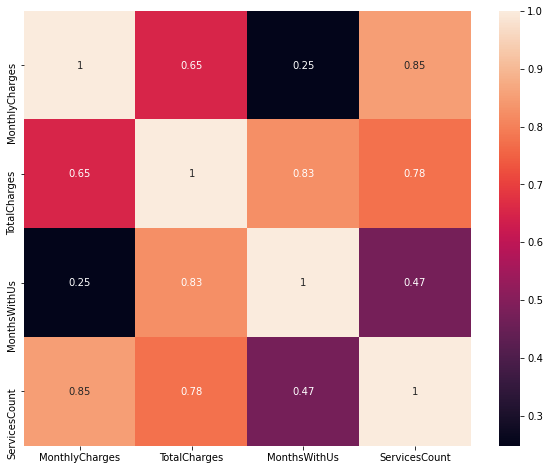

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(telecom[quantitive_columns].corr(), annot=True);

Высокая корреляция наблюдается у признаков MonthsWithUs и TotalCharges, что ожидаемо, так как MonthsWithUs = TotalCharges / MonthlyCharges. Признаки ServicesCount и MonthlyCharges тоже сильно коррелируют, но удалять не буду, так как смысл у этих прихнаков все-таки отличается. 

In [38]:
telecom = telecom.drop('TotalCharges', axis=1)
quantitive_columns.remove('TotalCharges')

<a id='EDA conclusion'></a>
### Вывод по EDA

#### Основные отличия между ушедшими и оставшимися пользователями:

1) 72% ушедших платили в месяц свыше 65. Среднемесячный платеж по оставшимся пользователям составляет 61, а по ушедшим 74.

2) 88% ушедших пользователей пользовались 'Month-to-month' (краткосрочным) контактом. Общие доли 55% (краткосрочный) и 45% (долгосрочный).

3) Основная масса уходящих, ушли в течении 20 месяцев (66%). 20% от ушедших пользовались услугами лишь один месяц.

4) Неженатые/незамужние занимают долю 64% в ушедших пользователях, при том что в общем количестве они занимают 52%.

5) Общая доля пользователей, которая использует и интернет и телефон составляет 69%, при этом в ушедших клиентах эта доля составляет 85%.

Все ушедшие ушли в период с октября 2019 по январь 2020, предполагаю что в этот период произошли крупные изменения, которые повлияли на отношение клиентов к компании. Исходя из наблюдений, приведенных выше, скорее всего значительно выросла стоимость услуг связанных с интернетом.

Так как эта информация является "утечкой" и она не поможет для предсказания в будущем, пользоваться месяцем ухода для предсказания я не буду.

<a id='Model training'></a>
## Обучение модели

<a id='Ordinal Encoding'></a>
### Кодирование категориальных признаков

Делаю порядковое кодирование:

In [39]:
telecom_ord = telecom.copy()
telecom_ord[categorical_columns].head()

,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,PhoneLines,UserType,ChargesGroup,MonthsGroup,Below20Months,Below65MonthPayment
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None,Internet only user,2,1,1,1
5575-GNVDE,One year,No,Mailed check,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,One,Internet and phone user,3,5,0,1
3668-QPYBK,Month-to-month,Yes,Mailed check,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,One,Internet and phone user,3,2,1,1
7795-CFOCW,One year,No,Bank transfer (automatic),DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,Internet only user,3,6,0,1
9237-HQITU,Month-to-month,Yes,Electronic check,Fiber optic,No,No,No,No,No,No,Female,0,No,No,One,Internet and phone user,4,2,1,0


In [40]:
encoder = OrdinalEncoder()

telecom_ord.loc[:, categorical_columns] = encoder.fit_transform(telecom_ord.loc[:, categorical_columns]).astype('int64')

In [41]:
telecom_ord[categorical_columns].head()

,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,PhoneLines,UserType,ChargesGroup,MonthsGroup,Below20Months,Below65MonthPayment
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,2,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,1,1
5575-GNVDE,1,0,3,0,1,0,1,0,0,0,1,0,0,0,2,0,2,4,0,1
3668-QPYBK,0,1,3,0,1,1,0,0,0,0,1,0,0,0,2,0,2,1,1,1
7795-CFOCW,1,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,2,5,0,1
9237-HQITU,0,1,2,1,0,0,0,0,0,0,0,0,0,0,2,0,3,1,1,0


Делаю OHE кодирование:

In [42]:
telecom_ohe = telecom.copy()
telecom_ohe[categorical_columns].head()

,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,PhoneLines,UserType,ChargesGroup,MonthsGroup,Below20Months,Below65MonthPayment
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None,Internet only user,2,1,1,1
5575-GNVDE,One year,No,Mailed check,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,One,Internet and phone user,3,5,0,1
3668-QPYBK,Month-to-month,Yes,Mailed check,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,One,Internet and phone user,3,2,1,1
7795-CFOCW,One year,No,Bank transfer (automatic),DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,Internet only user,3,6,0,1
9237-HQITU,Month-to-month,Yes,Electronic check,Fiber optic,No,No,No,No,No,No,Female,0,No,No,One,Internet and phone user,4,2,1,0


In [43]:
telecom_ohe.shape

(7043, 24)

In [44]:
telecom_ohe = pd.get_dummies(telecom_ohe, columns=categorical_columns, drop_first=True)

In [45]:
telecom_ohe.drop(quantitive_columns, axis=1).head()

,Churn,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,ChargesGroup_5,ChargesGroup_6,MonthsGroup_2,MonthsGroup_3,MonthsGroup_4,MonthsGroup_5,MonthsGroup_6,MonthsGroup_7,Below20Months_1,Below65MonthPayment_1
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5575-GNVDE,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
3668-QPYBK,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,1
7795-CFOCW,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
9237-HQITU,1,0,0,1,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [46]:
telecom_ohe.shape

(7043, 39)

<a id='Traintestsplit'></a>
### Подготовка обучающей и тестовой выборок

In [47]:
x_telecom_ord = telecom_ord.drop('Churn', axis=1)
y_telecom_ord = telecom_ord['Churn']
x_telecom_ohe = telecom_ohe.drop('Churn', axis=1)
y_telecom_ohe = telecom_ohe['Churn']

In [48]:
print('Распределение классов в датасете:')
display(telecom_ord['Churn'].value_counts(normalize=True))

Распределение классов в датасете:


0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [49]:
x_train_telecom_ord, x_test_telecom_ord, y_train_telecom_ord, y_test_telecom_ord = train_test_split(
    x_telecom_ord, y_telecom_ord, random_state=0, stratify=y_telecom_ord)

print(x_train_telecom_ord.shape, x_test_telecom_ord.shape, y_train_telecom_ord.shape, y_test_telecom_ord.shape)

x_train_telecom_ohe, x_test_telecom_ohe, y_train_telecom_ohe, y_test_telecom_ohe = train_test_split(
    x_telecom_ohe, y_telecom_ohe, random_state=0, stratify=y_telecom_ohe)

print(x_train_telecom_ohe.shape, x_test_telecom_ohe.shape, y_train_telecom_ohe.shape, y_test_telecom_ohe.shape)

(5282, 23) (1761, 23) (5282,) (1761,)
(5282, 38) (1761, 38) (5282,) (1761,)


In [50]:
print('Распределение классов в тренировочной выборке:')
display(y_train_telecom_ord.value_counts(normalize=True))
print('Распределение классов в тестовой выборке:')
display(y_test_telecom_ord.value_counts(normalize=True))

Распределение классов в тренировочной выборке:


0    0.73457
1    0.26543
Name: Churn, dtype: float64

Распределение классов в тестовой выборке:


0    0.73481
1    0.26519
Name: Churn, dtype: float64

<a id='Scaling'></a>
### Масштабирование

In [51]:
display(x_train_telecom_ord[quantitive_columns].head(2))
display(x_train_telecom_ohe[quantitive_columns].head(2))
display(x_test_telecom_ord[quantitive_columns].head(2))
display(x_test_telecom_ohe[quantitive_columns].head(2))

,MonthlyCharges,MonthsWithUs,ServicesCount
customerID,,,
6885-PKOAM,85.75,71.0,9.0
1064-FBXNK,19.85,1.0,1.0


,MonthlyCharges,MonthsWithUs,ServicesCount
customerID,,,
6885-PKOAM,85.75,71.0,9.0
1064-FBXNK,19.85,1.0,1.0


,MonthlyCharges,MonthsWithUs,ServicesCount
customerID,,,
2782-LFZVW,58.95,11.0,4.0
0098-BOWSO,19.40,27.0,1.0


,MonthlyCharges,MonthsWithUs,ServicesCount
customerID,,,
2782-LFZVW,58.95,11.0,4.0
0098-BOWSO,19.40,27.0,1.0


In [52]:
scaler = StandardScaler()

warnings.filterwarnings('ignore')
x_train_telecom_ord.loc[:, quantitive_columns] = scaler.fit_transform(x_train_telecom_ord.loc[:, quantitive_columns])
x_train_telecom_ohe.loc[:, quantitive_columns] = scaler.transform(x_train_telecom_ohe.loc[:, quantitive_columns])
x_test_telecom_ord.loc[:, quantitive_columns] = scaler.transform(x_test_telecom_ord.loc[:, quantitive_columns])
x_test_telecom_ohe.loc[:, quantitive_columns] = scaler.transform(x_test_telecom_ohe.loc[:, quantitive_columns])
warnings.filterwarnings('default')

In [53]:
display(x_train_telecom_ord[quantitive_columns].head(2))
display(x_train_telecom_ohe[quantitive_columns].head(2))
display(x_test_telecom_ord[quantitive_columns].head(2))
display(x_test_telecom_ohe[quantitive_columns].head(2))

,MonthlyCharges,MonthsWithUs,ServicesCount
customerID,,,
6885-PKOAM,0.710795,1.589131,2.112527
1064-FBXNK,-1.477313,-1.272574,-1.348640


,MonthlyCharges,MonthsWithUs,ServicesCount
customerID,,,
6885-PKOAM,0.710795,1.589131,2.112527
1064-FBXNK,-1.477313,-1.272574,-1.348640


,MonthlyCharges,MonthsWithUs,ServicesCount
customerID,,,
2782-LFZVW,-0.179058,-0.863759,-0.050702
0098-BOWSO,-1.492254,-0.209655,-1.348640


,MonthlyCharges,MonthsWithUs,ServicesCount
customerID,,,
2782-LFZVW,-0.179058,-0.863759,-0.050702
0098-BOWSO,-1.492254,-0.209655,-1.348640


<a id='Results table'></a>
### Подготовка таблицы с результатами

In [54]:
results = pd.DataFrame({'Model' : [], 'Train auc score' : [], 'Train accuracy score' : [],
                        'Test auc score' : [], 'Test accuracy score' : []})
results

,Model,Train auc score,Train accuracy score,Test auc score,Test accuracy score


In [55]:
def results_append (model : str, x_train, y_train, x_test, y_test, clf):
    globals()['results'] = globals()['results'].append({
        'Model' : model, 
        'Train auc score' : round(roc_auc_score(y_train, clf.predict_proba(x_train)[:, 1]), 3), 
        'Train accuracy score' : round(accuracy_score(y_train, clf.predict(x_train)), 3),
        'Test auc score' : round(roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1]), 3), 
        'Test accuracy score' : round(accuracy_score(y_test, clf.predict(x_test)), 3)},
        ignore_index=True)

<a id='Logistic Regression'></a>
### Logistic Regression

In [56]:
lr_space = {'penalty' : hp.choice('penalty', ['l1', 'l2', 'elasticnet']),
            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
            'C': hp.uniform('C', 0.00001, 1),
            'max_iter' : hp.quniform('max_iter', 100, 3000, 50)
           }

In [57]:
def lr_hyperopt(params):
    params = {'penalty': params['penalty'],
              'fit_intercept': params['fit_intercept'],
              'C': params['C'],
              'max_iter' : int(params['max_iter'])
             }
    
    lr = LogisticRegression(**params)
    score = cross_val_score(lr, x_train_telecom_ohe, y_train_telecom_ohe, scoring='roc_auc', cv=5, n_jobs=-1).mean()
    return -score

In [58]:
lr_best = fmin(fn=lr_hyperopt, space=lr_space, max_evals=10, rstate=np.random.RandomState(12345), algo=tpe.suggest)
lr_best = space_eval(lr_space, lr_best)

100%|███████████████████████████████████████████████| 10/10 [00:02<00:00,  4.16trial/s, best loss: -0.8490938320562478]


In [59]:
print(lr_best)

{'C': 0.40760899308973625, 'fit_intercept': True, 'max_iter': 2400.0, 'penalty': 'l2'}


In [60]:
lr_final = LogisticRegression(penalty = lr_best['penalty'], C = lr_best['C'], max_iter = int(lr_best['max_iter']))
lr_final.fit(x_train_telecom_ohe, y_train_telecom_ohe)

LogisticRegression(C=0.40760899308973625, max_iter=2400)

In [61]:
results_append('Logistic Regression', x_train_telecom_ohe, y_train_telecom_ohe, x_test_telecom_ohe, 
               y_test_telecom_ohe, lr_final)
results

,Model,Train auc score,Train accuracy score,Test auc score,Test accuracy score
0,Logistic Regression,0.854,0.81,0.851,0.801


<a id='LGB'></a>
### LightGBM

In [62]:
lgb_space = {'n_estimators' : hp.quniform('n_estimators', 500, 3000, 50),
             'learning_rate': hp.uniform('learning_rate', 0.00001, 2),
             'max_depth': hp.quniform('max_depth', 3, 100, 1),
             'num_leaves' : hp.quniform('num_leaves', 2, 100, 5),
             'min_child_samples' : hp.quniform('min_child_samples', 2, 100, 5),
             'subsample' : hp.uniform('subsample', 0.6, 1),
             'colsample_bytree' : hp.uniform('colsample_bytree', 0.6, 1),
             'reg_alpha' : hp.uniform('reg_alpha', 1, 15),
             'reg_lambda' : hp.uniform('reg_lambda', 1, 15)}

In [63]:
def lgb_hyperopt(params):
    params = {'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              'num_leaves' : int(params['num_leaves']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample' : params['subsample'],
              'colsample_bytree' : params['colsample_bytree'],
              'reg_alpha' : params['reg_alpha'],
              'reg_lambda' : params['reg_lambda']
             }
    
    lgb = lightgbm.LGBMClassifier(**params)
    score = cross_val_score(lgb, x_train_telecom_ord, y_train_telecom_ord, scoring='roc_auc', cv=5, n_jobs=-1).mean()
    return -score

In [64]:
lgb_best = fmin(fn=lgb_hyperopt, space=lgb_space, max_evals=40, rstate=np.random.RandomState(12345), algo=tpe.suggest)

100%|███████████████████████████████████████████████| 40/40 [00:48<00:00,  1.22s/trial, best loss: -0.8489271923594988]


In [65]:
print(lgb_best)

{'colsample_bytree': 0.8762479862955602, 'learning_rate': 0.06119820914018864, 'max_depth': 72.0, 'min_child_samples': 0.0, 'n_estimators': 3000.0, 'num_leaves': 60.0, 'reg_alpha': 14.955902851109885, 'reg_lambda': 14.347180864401635, 'subsample': 0.6632116515923062}


In [66]:
lgb_final = lightgbm.LGBMClassifier(n_estimators = int(lgb_best['n_estimators']), learning_rate = lgb_best['learning_rate'], 
                                   max_depth = int(lgb_best['max_depth']), num_leaves = int(lgb_best['num_leaves']), 
                                   min_child_samples = int(lgb_best['min_child_samples']), subsample = lgb_best['subsample'], 
                                   colsample_bytree = lgb_best['colsample_bytree'], reg_alpha = lgb_best['reg_alpha'], 
                                   reg_lambda = lgb_best['reg_lambda'])

lgb_final.fit(x_train_telecom_ord, y_train_telecom_ord, categorical_feature=categorical_columns)

c:\users\yansa\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMClassifier(colsample_bytree=0.8762479862955602,
               learning_rate=0.06119820914018864, max_depth=72,
               min_child_samples=0, n_estimators=3000, num_leaves=60,
               reg_alpha=14.955902851109885, reg_lambda=14.347180864401635,
               subsample=0.6632116515923062)

In [67]:
results_append('LightGBM', x_train_telecom_ord, y_train_telecom_ord, x_test_telecom_ord, 
               y_test_telecom_ord, lgb_final)
results

,Model,Train auc score,Train accuracy score,Test auc score,Test accuracy score
0,Logistic Regression,0.854,0.810,0.851,0.801
1,LightGBM,0.868,0.818,0.845,0.797


<a id='XGBoost'></a>
### XGBoost

In [68]:
xgb_space = {'n_estimators':hp.quniform('n_estimators', 500, 3000, 50),
             'gamma':hp.uniform('gamma', 0.01, 0.1),
             'learning_rate':hp.uniform('learning_rate', 0.00001, 2),
             'max_depth':hp.quniform('max_depth', 3, 100, 1),
             'subsample':hp.uniform('subsample', 0.60, 0.95),
             'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.98),
             'colsample_bylevel':hp.uniform('colsample_bylevel', 0.60, 0.98),
             'reg_lambda': hp.uniform('reg_lambda', 1, 20)
            }

In [69]:
def xgb_hyperopt(params):
    params = {'n_estimators': int(params['n_estimators']),
              'gamma': params['gamma'],
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'colsample_bylevel': params['colsample_bylevel'],
              'reg_lambda': params['reg_lambda']
             }
    
    xgb = xgboost.XGBClassifier(**params)
    score = cross_val_score(xgb, x_train_telecom_ohe, y_train_telecom_ohe, scoring='roc_auc', cv=5, n_jobs=-1).mean()
    return -score

In [70]:
xgb_best = fmin(fn=xgb_hyperopt, space=xgb_space, max_evals=40, rstate=np.random.RandomState(12345), algo=tpe.suggest)

100%|███████████████████████████████████████████████| 40/40 [15:59<00:00, 23.98s/trial, best loss: -0.8304256884863127]


In [71]:
print(xgb_best)

{'colsample_bylevel': 0.7331128272455502, 'colsample_bytree': 0.6307062347375482, 'gamma': 0.041300184029094994, 'learning_rate': 0.006943324325539901, 'max_depth': 100.0, 'n_estimators': 1100.0, 'reg_lambda': 2.405566901295222, 'subsample': 0.8959816496262265}


In [72]:
xgb_final = xgboost.XGBClassifier(n_estimators = int(xgb_best['n_estimators']), colsample_bytree = xgb_best['colsample_bytree'],
                                  gamma = xgb_best['gamma'], learning_rate = xgb_best['learning_rate'], 
                                  max_depth = int(xgb_best['max_depth']), subsample = xgb_best['subsample'], 
                                  colsample_bylevel = xgb_best['colsample_bylevel'], reg_lambda = xgb_best['reg_lambda'])

xgb_final.fit(x_train_telecom_ohe, y_train_telecom_ohe)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7331128272455502, colsample_bynode=1,
              colsample_bytree=0.6307062347375482, gamma=0.041300184029094994,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.006943324325539901, max_delta_step=0,
              max_depth=100, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0,
              reg_lambda=2.405566901295222, scale_pos_weight=1,
              subsample=0.8959816496262265, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [73]:
results_append('XGBoost', x_train_telecom_ohe, y_train_telecom_ohe, x_test_telecom_ohe, 
               y_test_telecom_ohe, xgb_final)
results

,Model,Train auc score,Train accuracy score,Test auc score,Test accuracy score
0,Logistic Regression,0.854,0.810,0.851,0.801
1,LightGBM,0.868,0.818,0.845,0.797
2,XGBoost,0.991,0.963,0.831,0.784


<a id='Logistic Regression + LightGBM'></a>
### Logistic Regression + LightGBM

In [74]:
proba_lr_train = lr_final.predict_proba(x_train_telecom_ohe)[:, 1]
proba_lgb_train = lgb_final.predict_proba(x_train_telecom_ord)[:, 1]

proba_lr_test = lr_final.predict_proba(x_test_telecom_ohe)[:, 1]
proba_lgb_test = lgb_final.predict_proba(x_test_telecom_ord)[:, 1]

In [75]:
mean_proba_train = (proba_lr_train + proba_lgb_train) / 2
mean_proba_test = (proba_lr_test + proba_lgb_test) / 2

lr_lgb_train_pred = np.round(mean_proba_train, 0).astype('int64')
lr_lgb_test_pred = np.round(mean_proba_test, 0).astype('int64')

In [76]:
results = results.append({'Model' : 'LR + LightGBM', 
                          'Train auc score' : round(roc_auc_score(y_train_telecom_ohe, mean_proba_train), 3),
                          'Train accuracy score' : round(accuracy_score(y_train_telecom_ohe, lr_lgb_train_pred), 3),
                          'Test auc score' : round(roc_auc_score(y_test_telecom_ohe, mean_proba_test), 3),
                          'Test accuracy score' : round(accuracy_score(y_test_telecom_ohe, lr_lgb_test_pred), 3)},
                         ignore_index=True)
results

,Model,Train auc score,Train accuracy score,Test auc score,Test accuracy score
0,Logistic Regression,0.854,0.810,0.851,0.801
1,LightGBM,0.868,0.818,0.845,0.797
2,XGBoost,0.991,0.963,0.831,0.784
3,LR + LightGBM,0.862,0.817,0.850,0.803


<a id='Conclusion'></a>
## Вывод

Получилось добиться максимального показателя 0.851 ROC-AUC и 0.8 accuracy. Из всех моделей лучше всего себя показала логистическая регрессия.

In [77]:
results.sort_values(by='Test auc score', ascending=False)

,Model,Train auc score,Train accuracy score,Test auc score,Test accuracy score
0,Logistic Regression,0.854,0.810,0.851,0.801
3,LR + LightGBM,0.862,0.817,0.850,0.803
1,LightGBM,0.868,0.818,0.845,0.797
2,XGBoost,0.991,0.963,0.831,0.784


#### Матрица ошибок и ROC кривая

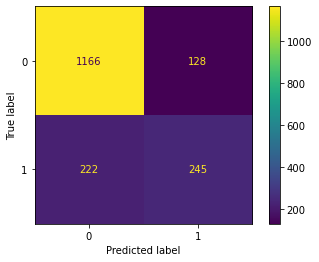

In [78]:
plot_confusion_matrix(estimator=lr_final, y_true = y_test_telecom_ohe, X = x_test_telecom_ohe);

90% пользователей, которые останутся предсказаны правильно, из всех ушедших получилось "поймать" 52%. 66% из тех кого определяем как уходяшего, действительно уходят, то есть с ушедшими ошибаемся в 34% случаев.

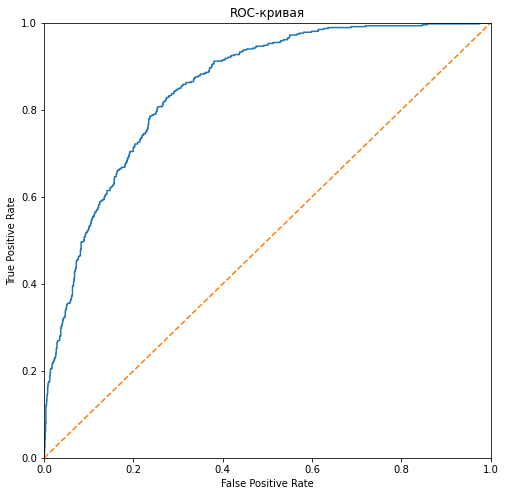

In [79]:
fpr, tpr, thresholds = roc_curve(y_test_telecom_ohe, lr_final.predict_proba(x_test_telecom_ohe)[:, 1])

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Влияние признаков

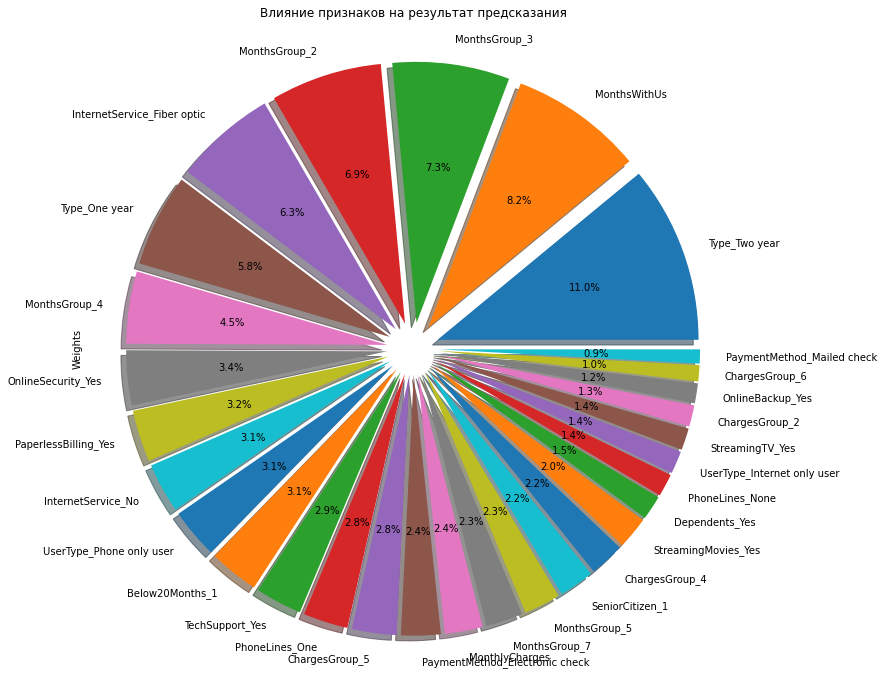

In [80]:
weights = lr_final.coef_
abs_weights = np.abs(weights)

feature_importances = pd.DataFrame({'Features' : list(x_train_telecom_ohe.columns),
                                    'Weights' : abs_weights[0]}).sort_values(by='Weights', ascending=False)
feature_importances

feature_importances[:30].plot.pie(explode=[0.1]*30,
                             labels = feature_importances.Features,
                             y = 'Weights', autopct='%1.1f%%', shadow=True, legend=False, figsize=(12, 12), 
                             title='Влияние признаков на результат предсказания');

Наиболее влияющие признаки: наличие 2хгодового типа контракта; кол-во месяцев, которые пользователь пробыл с нами; пробыл ли пользователь клиентом в течении 20 месяцев.